In [7]:
from ctrade import *
from plot import *
from datetime import datetime
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [8]:
p = Poloniex()

In [9]:
major = ['ETH', 'ETC', 'BCN', 'DASH', 'DOGE', 'LTC', 'NXT', 'REP', 'ZEC', 'ARDR', 'XRP', 'STR']

In [10]:
pairs = [i for i in p.currency_pairs if 'USDT_' in i]
pairs += [i for i in p.currency_pairs if any([j for j in major if 'BTC_'+j in i])]

In [11]:
inf = lambda x: np.isinf(x)

def build_dataset(currency_pairs, days_back, period):
    out = pd.DataFrame()
    for i in currency_pairs:
        print(i)
        t = p.chart(i, days_back, period).df
        t[i+'_PC'] = (t['close'] - t['close'].shift(1))/t['close']
        t = t.rename(columns={'close': i})
        t[i+'_volume'] = t['volume']
        t[i+'_volume_PC'] = (t[i+'_volume'] - t[i+'_volume'].shift(1))/t[i+'_volume']
        t[i+'_volume_PC'] = t[i+'_volume_PC'].fillna(0)
        mask = t[i+'_volume_PC'].apply(inf)
        t.loc[mask, i+'_volume_PC'] = 0
        out = pd.concat([out, t[[i+'_PC', i+'_volume_PC', i, i+'_volume']]], axis=1)
    
    df = out[currency_pairs + [i+'_volume' for i in currency_pairs]]
    out = out[out[i+'_PC'].notnull()]
    return out[[i for i in out.columns if i not in currency_pairs]], df

In [12]:
df = p.chart('BTC_ETH', 60, '15m').df
df['value'] = (df['open'] + df['close'])*0.5
df2 = p.chart('USDT_BTC', 60, '15m').df
df2['value'] = (df2['open'] + df2['close'])*0.5

In [13]:
df = moving_average_convergence(df, 'value', 50, 15)
df2 = moving_average_convergence(df2, 'value', 50, 15)

In [14]:
df, q = tag_ranges(df, 'macd_15-50', (0.03,0.97))
df2, q2 = tag_ranges(df2, 'macd_15-50', (0.03,0.97))

(-1.7882151496105143, 2.0833520026682049)
(-2.0984866427502644, 1.7602385026404512)


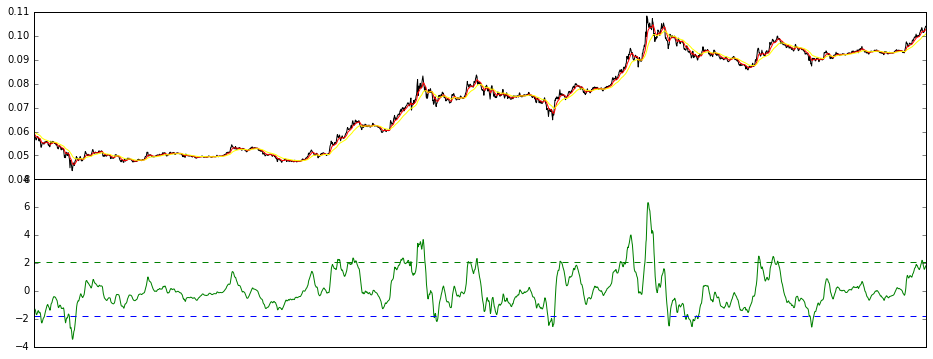

In [15]:
fig = plt.figure(figsize=(16,6))
fig.subplots_adjust(hspace=0)
ax = fig.add_subplot(211)
_ = plot_fts(df, 'value', ax=ax, since=datetime(2017, 5, 8), plot_args={'color': 'black'})
_ = plot_fts(df, 'value_ewma15', ax=ax, since=datetime(2017, 5, 8), plot_args={'color': 'red'})
_ = plot_fts(df, 'value_ewma50', ax=ax, since=datetime(2017, 5, 8), plot_args={'color': 'yellow'})

ax = fig.add_subplot(212)
_ = plot_fts(df, 'macd_15-50', ax=ax, since=datetime(2017, 5, 8), plot_args={'color': 'green'})
ax.plot(ax.get_xlim(), [q[0],q[0]], '--')
ax.plot(ax.get_xlim(), [q[1],q[1]], '--')

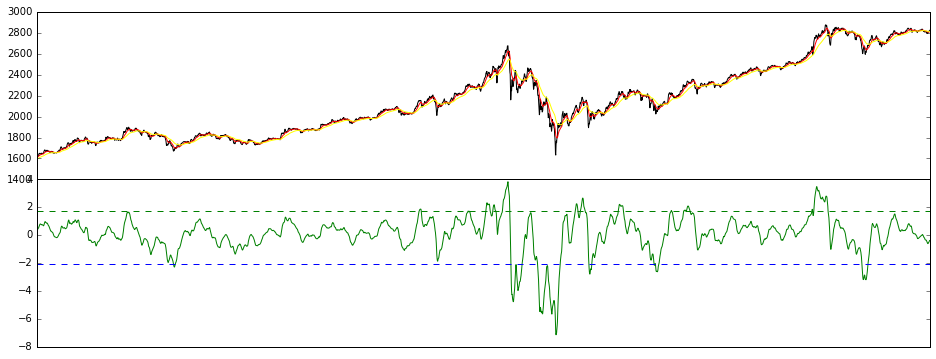

In [16]:
fig = plt.figure(figsize=(16,6))
fig.subplots_adjust(hspace=0)
ax = fig.add_subplot(211)
_ = plot_fts(df2, 'value', ax=ax, since=datetime(2017, 5, 8), plot_args={'color': 'black'})
_ = plot_fts(df2, 'value_ewma15', ax=ax, since=datetime(2017, 5, 8), plot_args={'color': 'red'})
_ = plot_fts(df2, 'value_ewma50', ax=ax, since=datetime(2017, 5, 8), plot_args={'color': 'yellow'})

ax = fig.add_subplot(212)
_ = plot_fts(df2, 'macd_15-50', ax=ax, since=datetime(2017, 5, 8), plot_args={'color': 'green'})
ax.plot(ax.get_xlim(), [q2[0],q2[0]], '--')
ax.plot(ax.get_xlim(), [q2[1],q2[1]], '--')

In [17]:
def which_q(df, column, value):

    x = ((df.sort_values(column, ascending=True)[column] - value)>0)*1
    return (x==0).sum()/float(x.shape[0])

In [20]:
def simulate_sell(x, prices):
    state = ['start']
    profit = ['start']
    sell_price = []
    for index in range(len(x)):
        if state[-1]=='S' and x[index]==1:
            gain = (sell_price - prices[index])/sell_price
            profit.append(gain)
            state.append('C'),
        elif (state[-1]=='C' or state[-1]=='start') and x[index]==-1 :
            state.append('S')
            sell_price = prices[index]

    return state, profit

def simulate_buy(x, prices):
    state = ['start']
    profit = ['start']
    sell_price = []
    for index in range(len(x)):
        if state[-1]=='B' and x[index]==-1:
            gain = (prices[index] - sell_price)/sell_price
            profit.append(gain)
            state.append('C'),
        elif (state[-1]=='C' or state[-1]=='start') and x[index]==1 :
            state.append('B')
            sell_price = prices[index]

    return state, profit

def simulate_buy_sell(x, prices, dates):
    state = ['start']
    profit = ['start']
    sell_price = []
    date = []
    for index in range(len(x)):
        if state[-1]=='B' and x[index]==-1:
            gain = (prices[index] - sell_price)/sell_price
            print 'CB', prices[index], gain
            profit.append(gain)
            state.append('C'),
            date[-1] += [dates[index]]
        elif (state[-1]=='C' or state[-1]=='start') and x[index]==1 :
            state.append('B')
            sell_price = prices[index]
            print 'B', prices[index]
            date.append(['B', dates[index]])
        elif state[-1]=='S' and x[index]==1:
            gain = (sell_price - prices[index])/sell_price
            profit.append(gain)
            state.append('C')
            print 'CS', prices[index], gain
            date[-1] += [dates[index]]
        elif (state[-1]=='C' or state[-1]=='start') and x[index]==-1 :
            state.append('S')
            sell_price = prices[index]
            print 'S', prices[index]
            date.append(['S', dates[index]])

            
    return state, profit, date

In [21]:
a, b, c = simulate_buy_sell(df['macd_15-50_tag'].tolist(), df['value'].tolist(), df2.index.tolist())

B 0.052224965
CB 0.061779995 0.182959050332
S 0.06198255
CS 0.054049555 0.127987554562
B 0.053400945
CB 0.058745835 0.100089801782
S 0.05817001
CS 0.07200001 -0.237751377385
B 0.073861575
CB 0.07965 0.0783685563163
S 0.0791255
CS 0.06883215 0.130088909391
B 0.067650495
CB 0.076128345 0.125318373502
S 0.075252755
CS 0.095690005 -0.271581419179
B 0.09468851
CB 0.094847405 0.00167808111037
S 0.094795535
CS 0.0896716 0.0540524930842
B 0.090912475
CB 0.103438455 0.137780651115
S 0.103390295


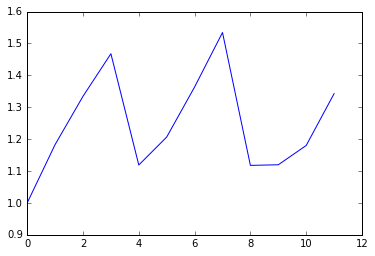

In [22]:
res = pd.DataFrame(np.array([0] + b[1:])+1, index=range(len(b)), columns=['perf'])
res['pnl'] = res['perf'].cumprod()
plt.plot(range(len(res)), res['pnl'])

In [23]:
trades = pd.DataFrame(c[:-1], columns=['trade', 'open', 'close'])
trades_sell = trades[trades['trade'] == 'S']
trades_bought = trades[trades['trade'] == 'B']

In [24]:
trades_sell

,trade,open,close
1,S,2017-05-05 01:45:00,2017-05-08 06:30:00
3,S,2017-05-19 09:45:00,2017-05-23 00:30:00
5,S,2017-05-24 07:15:00,2017-05-27 06:45:00
7,S,2017-05-27 18:00:00,2017-05-31 18:45:00
9,S,2017-06-04 04:15:00,2017-06-06 01:45:00


In [25]:
trades_bought

,trade,open,close
0,B,2017-05-01 18:00:00,2017-05-05 01:30:00
2,B,2017-05-08 06:45:00,2017-05-19 09:30:00
4,B,2017-05-23 00:45:00,2017-05-24 07:00:00
6,B,2017-05-27 07:00:00,2017-05-27 17:45:00
8,B,2017-05-31 19:00:00,2017-06-04 04:00:00
10,B,2017-06-06 02:00:00,2017-06-10 07:00:00


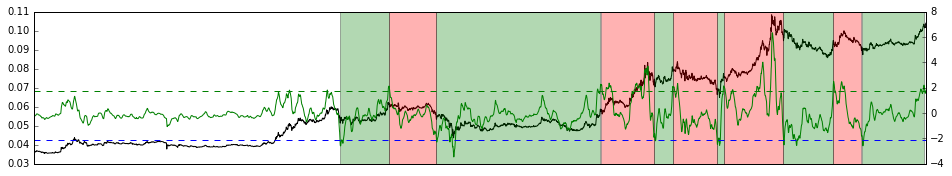

In [26]:
fig = plt.figure(figsize=(16,6))
# fig.subplots_adjust(hspace=0)
ax = fig.add_subplot(211)
ax = plot_fts(df, 'value', ax=ax, plot_args={'color': 'black'})

ax = ax.twinx()
_ = plot_fts(df, 'macd_15-50', ax=ax, plot_args={'color': 'green'})

ax.plot(ax.get_xlim(), [q2[0],q2[0]], '--')
ax.plot(ax.get_xlim(), [q2[1],q2[1]], '--')


ymin, ymax = ax.get_ylim()[0], ax.get_ylim()[1]

opened = [df.index.get_loc(i) for i in trades_bought['open']]
closed = [df.index.get_loc(i) for i in trades_bought['close']]

for iop, op in enumerate(opened):
    ax.axvspan(op, closed[iop], ymin, ymax, facecolor='g', alpha=.3 )

opened = [df.index.get_loc(i) for i in trades_sell['open']]
closed = [df.index.get_loc(i) for i in trades_sell['close']]
for iop, op in enumerate(opened):
    ax.axvspan(op, closed[iop], ymin, ymax, facecolor='r', alpha=.3 )

In [27]:
a, b, c = simulate_buy_sell(df2['macd_15-50_tag'].tolist(), df2['value'].tolist(), df2.index.tolist())

B 1670.43937958
CB 2149.42294236 0.286741062645
S 2151.33849999
CS 2209.0 -0.0268026161435
B 2290.0
CB 2088.43913257 -0.0880178460415
S 2093.95595385
CS 1933.5 0.0766281418434
B 1930.76462034
CB 2219.49999997 0.149544577621
S 2217.34773614
CS 2064.45 0.0689552358649
B 2091.45
CB 2227.21356096 0.06491360585
S 2284.63434999
CS 2646.04100199 -0.158190150648
B 2638.58250471


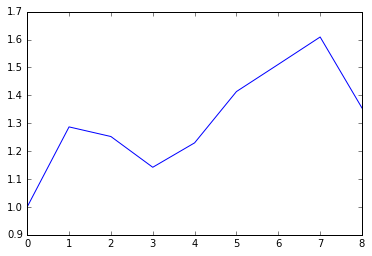

In [28]:
res = pd.DataFrame(np.array([0] + b[1:])+1, index=range(len(b)), columns=['perf'])
res['pnl'] = res['perf'].cumprod()
plt.plot(range(len(res)), res['pnl'])

In [29]:
trades = pd.DataFrame(c[:-1], columns=['trade', 'open', 'close'])
trades_sell = trades[trades['trade'] == 'S']
trades_bought = trades[trades['trade'] == 'B']

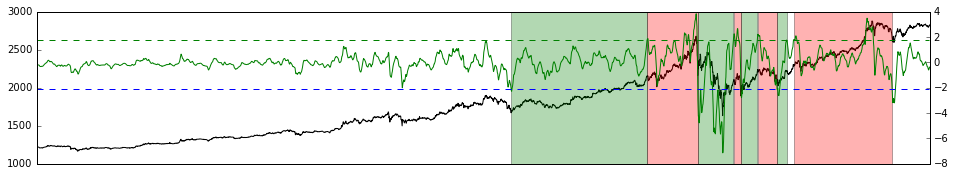

In [30]:
fig = plt.figure(figsize=(16,6))
# fig.subplots_adjust(hspace=0)
ax = fig.add_subplot(211)
ax = plot_fts(df2, 'value', ax=ax, plot_args={'color': 'black'})

ax = ax.twinx()
_ = plot_fts(df2, 'macd_15-50', ax=ax, plot_args={'color': 'green'})

ax.plot(ax.get_xlim(), [q2[0],q2[0]], '--')
ax.plot(ax.get_xlim(), [q2[1],q2[1]], '--')


ymin, ymax = ax.get_ylim()[0], ax.get_ylim()[1]

opened = [df2.index.get_loc(i) for i in trades_bought['open']]
closed = [df2.index.get_loc(i) for i in trades_bought['close']]

for iop, op in enumerate(opened):
    ax.axvspan(op, closed[iop], ymin, ymax, facecolor='g', alpha=.3 )

opened = [df2.index.get_loc(i) for i in trades_sell['open']]
closed = [df2.index.get_loc(i) for i in trades_sell['close']]
for iop, op in enumerate(opened):
    ax.axvspan(op, closed[iop], ymin, ymax, facecolor='r', alpha=.3 )